# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from loadcreon import LoadCreon
from creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search
from repeatedsampling import RepeatedRandomSubSampler

In [4]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import clone

In [6]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

# FIRST REPEATED SUB SAMPLER

## Set up PNU Wrapper with Random Forest, then JeffSearchCV, then NestedCV

In [43]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
rep = RepeatedRandomSubSampler(base_estimator=rf, verbose=1)
pnu = PNUWrapper(base_estimator=rep, num_unlabeled=1.0)

## Set up randomized search parameters

In [7]:
rf_param_search = {'base_estimator__base_estimator':[rf, et],
 'base_estimator__base_estimator__bootstrap': [True, False],
 'base_estimator__base_estimator__class_weight': [None,'balanced','balanced_subsample'],
 'base_estimator__base_estimator__criterion': ['gini','entropy'],
 'base_estimator__base_estimator__max_depth': [None] + list(range(2,100)),
 'base_estimator__base_estimator__max_features': ['sqrt','log2',None] + list(range(5,100)),
 'base_estimator__base_estimator__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
 'base_estimator__base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
 'base_estimator__base_estimator__n_estimators': sp.stats.randint(low=10, high=300),
 'base_estimator__sample_imbalance': sp.stats.uniform(loc=0.1, scale=0.9),
 'pu_learning': [True, False]
                  }

### notice random_state is set in jeffsearch, this is so that the same random parameters are searched for each outer fold, sort of like grid search

In [8]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=60, scoring=FrankenScorer(decision_score='assumed_f1beta10'),
                                n_jobs=-1, cv=3, verbose=1, pre_dispatch=8, random_state=77)

#### 3x3 (x60) nested cross validation

In [9]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer(decision_score='assumed_f1beta10'), cv=3, random_state=None)

## Score the nested cross

In [10]:
scores = nested_cross.score(X_train.values, y=y_train.values, verbose=100, pre_dispatch=8)

[CV]  ................................................................
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 112.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 489.4min finished


generating 137 samples of indices to use to train multiple estimators,               sized 2830 elements with last being 1524 elements


[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.6min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.6min finished


[CV]  , score=0.702562296381 score_data={'labeled_acc': 0.82011834319526622, 'assumed_f1beta10': 0.70256229638108647, 'assumed_brier_neg': 0.095473052356552665, 'labeled_brier_pos': 0.16992182157136196, 'assumed_brier': 0.095825911141888376, 'labeled_roc_auc': 0.80570204967085568, 'pu_score': 6.8401854874045922, 'pr_one_unlabeled': 0.10198414398971502, 'confusion_matrix_un': array([[104995,  11968],
       [    83,    474]]), 'labeled_f1': 0.86181818181818171, 'labeled_brier': 0.17982954499036324, 'confusion_matrix_lab': array([[219,  69],
       [ 83, 474]]), 'assumed_f1': 0.072928686822063243, 'labeled_prec': 0.8729281767955801, 'labeled_brier_neg': 0.19899135729725112, 'SCORE': 0.70256229638108647, 'labeled_recall': 0.85098743267504484, 'labeled_avg_prec': 0.9110702307708155}, total=505.9min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 537.2min remaining:    0.0s
[CV]  ................................................................
Fitting 3 folds for each of 60 candidates,

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 117.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 529.8min finished


generating 137 samples of indices to use to train multiple estimators,               sized 2830 elements with last being 1525 elements


[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.3min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.4min finished


[CV]  , score=0.70122764265 score_data={'labeled_acc': 0.81872037914691942, 'assumed_f1beta10': 0.70122764265023685, 'assumed_brier_neg': 0.074222194234285888, 'labeled_brier_pos': 0.14428425002048584, 'assumed_brier': 0.074554264495885439, 'labeled_roc_auc': 0.82127687524631066, 'pu_score': 8.141926515967004, 'pr_one_unlabeled': 0.077523034068995078, 'confusion_matrix_un': array([[107868,   9094],
       [   104,    453]]), 'labeled_f1': 0.85552407932011321, 'labeled_brier': 0.14973095356007535, 'confusion_matrix_lab': array([[238,  49],
       [104, 453]]), 'assumed_f1': 0.089667458432304017, 'labeled_prec': 0.90239043824701193, 'labeled_brier_neg': 0.16030173360032404, 'SCORE': 0.70122764265023685, 'labeled_recall': 0.81328545780969475, 'labeled_avg_prec': 0.91944932243593624}, total=548.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 1116.8min remaining:    0.0s
[CV]  ................................................................
Fitting 3 folds for each of 60 candidate

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 118.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 564.8min finished


generating 137 samples of indices to use to train multiple estimators,               sized 2833 elements with last being 1255 elements


[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.4min finished


[CV]  , score=0.707446235318 score_data={'labeled_acc': 0.83867141162514824, 'assumed_f1beta10': 0.70744623531766204, 'assumed_brier_neg': 0.073830485701749118, 'labeled_brier_pos': 0.13907766980805419, 'assumed_brier': 0.074139185161087792, 'labeled_roc_auc': 0.8481970521144061, 'pu_score': 8.4090020631052518, 'pr_one_unlabeled': 0.076015221900337687, 'confusion_matrix_un': array([[108057,   8904],
       [   101,    455]]), 'labeled_f1': 0.86998087954110903, 'labeled_brier': 0.1389149549523232, 'confusion_matrix_lab': array([[252,  35],
       [101, 455]]), 'assumed_f1': 0.091780131114473015, 'labeled_prec': 0.9285714285714286, 'labeled_brier_neg': 0.13859973035376419, 'SCORE': 0.70744623531766204, 'labeled_recall': 0.81834532374100721, 'labeled_avg_prec': 0.93336347698658562}, total=584.0min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 1731.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 1731.7min finished


## The scores of the 3 folds of the outer loop

In [14]:
scores

(0.70256229638108647, 0.70122764265023685, 0.70744623531766204)

In [12]:
save_search(nested_cross, './res/nested_cross_repreated_rf_large_20170131.pkl')

In [4]:
nested_cross = load_search('./res/nested_cross_repreated_rf_large_20170131.pkl')

In [5]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0815065
assumed_brier_neg                                                  0.0811752
assumed_f1                                                         0.0847921
assumed_f1beta10                                                    0.703745
confusion_matrix_lab          [[236.333333333, 51.0], [96.0, 460.666666667]]
confusion_matrix_un        [[106973.333333, 9988.66666667], [96.0, 460.66...
fn_confusion_matrix_lab                                                   96
fn_confusion_matrix_un                                                    96
fp_confusion_matrix_lab                                                   51
fp_confusion_matrix_un                                               9988.67
labeled_acc                                                         0.825837
labeled_avg_prec                                                    0.921294
labeled_brier                                                       0.156158

In [10]:
[est.best_index_ for est in nested_cross.estimators_]

[57, 57, 57]

In [6]:
t = extract_score_grid(nested_cross.estimators_[0])
t['optimize_score'] = t.mean_pu_score_test + (t.mean_assumed_f1beta10_test * 100)
t[['mean_pu_score_test','mean_assumed_f1beta10_test','optimize_score','mean_pr_one_unlabeled_test']].iloc[34]

mean_pu_score_test            11.311659
mean_assumed_f1beta10_test     0.689577
optimize_score                80.269381
mean_pr_one_unlabeled_test     0.046951
Name: 34, dtype: float64

## Let's rescore for estimator 34, looks a little better than 57 based on PU + f1beta10

In [7]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
rep_test = RepeatedRandomSubSampler(base_estimator=rf, verbose=1)
pnu_test = PNUWrapper(base_estimator=rep_test, num_unlabeled=1.0)
pnu_test.set_params(**{'base_estimator__base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=64, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
              verbose=0, warm_start=False),
  'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 64,
  'base_estimator__base_estimator__max_features': 87,
  'base_estimator__base_estimator__min_samples_leaf': 8,
  'base_estimator__base_estimator__min_samples_split': 0.01,
  'base_estimator__base_estimator__n_estimators': 79,
  'base_estimator__sample_imbalance': 0.44063408204723742,
  'pu_learning': True})

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weigh...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [16]:
from nestedcross import rerun_nested_for_estimator

In [17]:
nested_cross = rerun_nested_for_estimator(nested_cross, pnu_test, X_train.values, y_train.values, n_jobs=-1)

In [18]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0481334
assumed_brier_neg                                                  0.0476343
assumed_f1                                                           0.11211
assumed_f1beta10                                                    0.715132
confusion_matrix_lab       [[248.666666667, 38.6666666667], [110.0, 446.6...
confusion_matrix_un        [[109992.666667, 6969.33333333], [110.0, 446.6...
fn_confusion_matrix_lab                                                  110
fn_confusion_matrix_un                                                   110
fp_confusion_matrix_lab                                              38.6667
fp_confusion_matrix_un                                               6969.33
labeled_acc                                                         0.823858
labeled_avg_prec                                                    0.926619
labeled_brier                                                       0.143381

# Let's dive in and see the parameters for one of the best models

In [43]:
[est.cv_results_['params'][34] for est in nested_cross.estimators_]

[{'base_estimator__base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=64, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
              verbose=0, warm_start=False),
  'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 64,
  'base_estimator__base_estimator__max_features': 87,
  'base_estimator__base_estimator__min_samples_leaf': 8,
  'base_estimator__base_estimator__min_samples_split': 0.01,
  'base_estimator__base_estimator__n_estimators': 79,
  'base_estimator__sample_imbalance': 0.44063408204723742,
  'pu_learning': True},
 {'base_estimator__base_estimator': RandomFores

## Let's see what feature importance looks like for this specific estimator

In [20]:
feature_importances = np.array([est.best_estimator_.feature_importances_ for est in nested_cross.estimators_])

In [21]:
feature_importance = np.mean(feature_importances, axis=0)

In [23]:
cc = X_test.columns.values
cc = np.insert(cc, 109, ['CPT_FLAG44_Sum'])
len(cc)

288

In [24]:
X_test.columns[X_test.columns.str.contains('CPT')]

Index(['CPT_FLAG1_Sum', 'CPT_FLAG2_Sum', 'CPT_FLAG3_Sum', 'CPT_FLAG4_Sum',
       'CPT_FLAG5_Sum', 'CPT_FLAG6_Sum', 'CPT_FLAG7_Sum', 'CPT_FLAG8_Sum',
       'CPT_FLAG9_Sum', 'CPT_FLAG10_Sum', 'CPT_FLAG11_Sum', 'CPT_FLAG12_Sum',
       'CPT_FLAG13_Sum', 'CPT_FLAG14_Sum', 'CPT_FLAG15_Sum', 'CPT_FLAG16_Sum',
       'CPT_FLAG17_Sum', 'CPT_FLAG18_Sum', 'CPT_FLAG19_Sum', 'CPT_FLAG20_Sum',
       'CPT_FLAG21_Sum', 'CPT_FLAG22_Sum', 'CPT_FLAG26_Sum', 'CPT_FLAG29_Sum',
       'CPT_FLAG32_Sum', 'CPT_FLAG33_Sum', 'CPT_FLAG34_Sum', 'CPT_FLAG35_Sum',
       'CPT_FLAG36_Sum', 'CPT_FLAG37_Sum', 'CPT_FLAG43_Sum', 'CPT_FLAG45_Sum',
       'CPT_FLAG46_Sum', 'CPT_FLAG47_Sum', 'CPT_FLAG48_Sum', 'CPT_FLAG49_Sum'],
      dtype='object')

In [25]:
c = pd.DataFrame(list(enumerate(cc)))
c[c[1].str.contains('CPT')]

,0,1
78,78,CPT_FLAG1_Sum
79,79,CPT_FLAG2_Sum
80,80,CPT_FLAG3_Sum
81,81,CPT_FLAG4_Sum
82,82,CPT_FLAG5_Sum
83,83,CPT_FLAG6_Sum
84,84,CPT_FLAG7_Sum
85,85,CPT_FLAG8_Sum
86,86,CPT_FLAG9_Sum
87,87,CPT_FLAG10_Sum


In [44]:
importance = pd.DataFrame(feature_importance, index=cc, columns=['Importance']).sort_values(by='Importance', ascending=False)
importance.round(5) * 100

,Importance
DIAG_FLAG4_Sum,33.557
DIAG_FLAG5_Sum,20.414
ndc_cat58_Sum,6.526
CPT_FLAG9_Sum,4.300
ndc_cat87_Sum,3.695
DIAG_FLAG75_Sum,3.290
ndc_cat54_Sum,1.936
CPT_FLAG43_Sum,1.368
DIAG_FLAG42_Sum,1.265
age,1.173


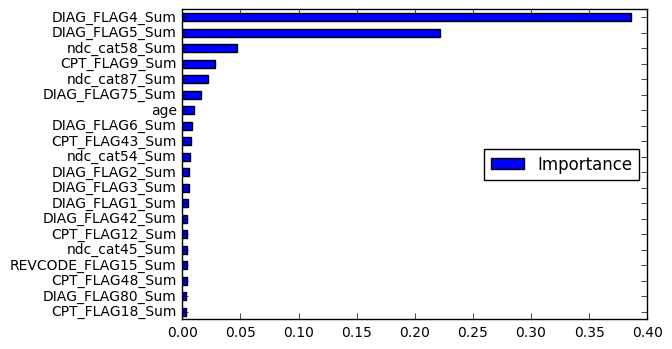

In [46]:
ax = importance.iloc[:20].iloc[::-1].plot(kind='barh')
ax.legend(loc='right')

## This is model 6 in draft, lets retrain on whole training set and then test on test set!

In [7]:
pnu_test.fit(X_train.values, y_train.values)

generating 93 samples of indices to use to train multiple estimators, sized 5459 elements with last being 3106 elements


[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:  2.5min finished


PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=0.01, min_weight...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [8]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   50.4s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   49.2s finished


({'SCORE': 0.85532994923857864,
  'assumed_brier': 0.047232849473650876,
  'assumed_brier_neg': 0.046790558595351722,
  'assumed_f1': 0.11562875278778523,
  'assumed_f1beta10': 0.72095486221431448,
  'confusion_matrix_lab': array([[182,  33],
         [ 81, 337]]),
  'confusion_matrix_un': array([[82648,  5074],
         [   81,   337]]),
  'labeled_acc': 0.81990521327014221,
  'labeled_avg_prec': 0.92249649590632388,
  'labeled_brier': 0.13804548135459391,
  'labeled_brier_neg': 0.13414334042471771,
  'labeled_brier_pos': 0.14005256341182684,
  'labeled_f1': 0.85532994923857864,
  'labeled_prec': 0.91081081081081083,
  'labeled_recall': 0.80622009569377995,
  'labeled_roc_auc': 0.8263658618003783,
  'pr_one_unlabeled': 0.057606820025826504,
  'pu_mix_assumed_f1beta10': 82.683213605578729,
  'pu_score': 10.587727384147289},
 0.85532994923857864)

In [13]:
pnu_test.set_params(**{'base_estimator__voting':'soft'})

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=0.01, min_weight...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='soft'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [14]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   50.9s finished


({'SCORE': 0.85387547649301154,
  'assumed_brier': 0.047232849473650876,
  'assumed_brier_neg': 0.046790558595351722,
  'assumed_f1': 0.11504879301489471,
  'assumed_f1beta10': 0.71863286957626582,
  'confusion_matrix_lab': array([[182,  33],
         [ 82, 336]]),
  'confusion_matrix_un': array([[82635,  5087],
         [   82,   336]]),
  'labeled_acc': 0.81832543443917849,
  'labeled_avg_prec': 0.92196936051312495,
  'labeled_brier': 0.13804548135459391,
  'labeled_brier_neg': 0.13414334042471771,
  'labeled_brier_pos': 0.14005256341182684,
  'labeled_f1': 0.85387547649301154,
  'labeled_prec': 0.91056910569105687,
  'labeled_recall': 0.80382775119617222,
  'labeled_roc_auc': 0.82516968955157444,
  'pr_one_unlabeled': 0.057755379569634432,
  'pu_mix_assumed_f1beta10': 82.364982731865098,
  'pu_score': 10.501695774238506},
 0.85387547649301154)

# Feature importance for 80/20

In [47]:
importance = pd.DataFrame(pnu_test.feature_importances_, index=X_test.columns.values, columns=['Importance']).sort_values(by='Importance', ascending=False)
importance.round(5) * 100

,Importance
DIAG_FLAG4_Sum,38.638
DIAG_FLAG5_Sum,22.201
ndc_cat58_Sum,4.747
CPT_FLAG9_Sum,2.793
ndc_cat87_Sum,2.197
DIAG_FLAG75_Sum,1.628
age,1.018
DIAG_FLAG6_Sum,0.868
CPT_FLAG43_Sum,0.712
ndc_cat54_Sum,0.692


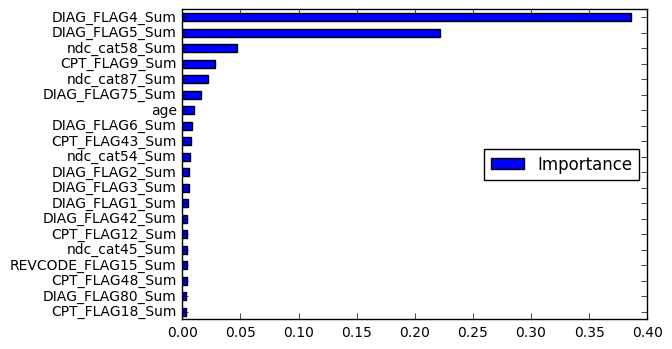

In [48]:
ax = importance.iloc[:20].iloc[::-1].plot(kind='barh')
ax.legend(loc='right')

# Probability distribution of the 20%

In [15]:
probas = pnu_test.predict_proba(X_test)[:, -1]

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   49.9s finished


In [16]:
probas_df = pd.DataFrame(data={'probas':probas, 'y_test':y_test.values}).sort_values(by='probas', ascending=False)

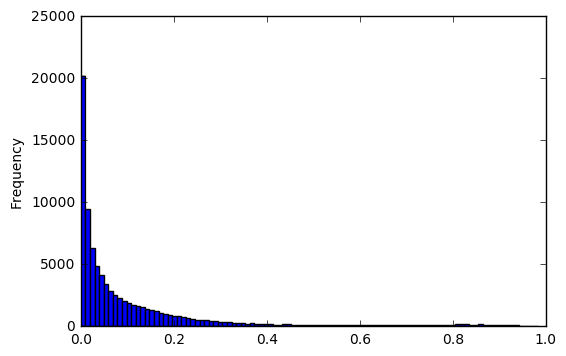

In [143]:
probas_df['probas'].plot.hist(bins=100)

In [17]:
bins = np.linspace(0.0, 1.0, 101)
percent = pd.cut(probas_df['probas'], bins=bins, include_lowest=True, precision=6, labels=list(range(0,100)))
probas_df['percent'] = percent

In [19]:
probas_df.to_csv('./res/predicted_probabilities.csv')

In [20]:
probas_df.head()

,probas,y_test,percent
72609,0.972751,-1,97
73802,0.972007,-1,97
342,0.967370,1,96
63807,0.966584,-1,96
34531,0.965232,-1,96


In [21]:
dummies = pd.get_dummies(probas_df['y_test'], prefix='y=', prefix_sep='')

In [22]:
probas_df = pd.concat([probas_df, dummies], axis=1)

In [23]:
probas_group = probas_df.groupby('percent')

In [24]:
percentile_df = probas_group.aggregate({'probas':'count', 'y=-1':'sum', 'y=0':'sum', 'y=1':'sum'})

In [25]:
percentile_df.head()

,y=0,probas,y=-1,y=1
percent,,,,
0,0.0,11783,11781.0,2.0
1,4.0,9184,9180.0,0.0
2,5.0,7374,7366.0,3.0
3,7.0,5867,5860.0,0.0
4,11.0,4960,4948.0,1.0


In [26]:
labeled_tot = percentile_df['y=1'] + percentile_df['y=0']
percentile_df['unlabeled_pct'] = percentile_df['y=-1'] / percentile_df.probas
percentile_df['true_pos_pct'] = percentile_df['y=1'] / labeled_tot
percentile_df['true_neg_pct'] = percentile_df['y=0'] / labeled_tot

In [27]:
percentile_df.tail()

,y=0,probas,y=-1,y=1,unlabeled_pct,true_pos_pct,true_neg_pct
percent,,,,,,,
95,0.0,30,23.0,7.0,0.766667,1.0,0.0
96,0.0,9,7.0,2.0,0.777778,1.0,0.0
97,0.0,2,2.0,0.0,1.000000,NaN,NaN
98,NaN,0,NaN,NaN,NaN,NaN,NaN
99,NaN,0,NaN,NaN,NaN,NaN,NaN


In [35]:
percentile_df.to_csv('./res/percentage_table.csv')

In [28]:
tot = percentile_df.probas.sum()
percentile_df['pct_of_total'] = percentile_df.probas / tot

In [29]:
percentile_df['cum_pct_of_total'] = percentile_df.pct_of_total.cumsum()

In [30]:
percentile_df = percentile_df.ffill()

In [31]:
tp = np.polyfit(x=percentile_df.index.values.astype(int), y=percentile_df.true_pos_pct, deg=1)
tpp = np.poly1d(tp)
percentile_df['tp_trendline'] = tpp(percentile_df.index.values.astype(int))

In [32]:
tn = np.polyfit(x=percentile_df.index.values.astype(int), y=percentile_df.true_neg_pct, deg=1)
tnp = np.poly1d(tn)
percentile_df['tn_trendline'] = tnp(percentile_df.index.values.astype(int))

In [33]:
import matplotlib.pyplot as plt

In [34]:
df = percentile_df
x_axis = df.index.values.astype(int)

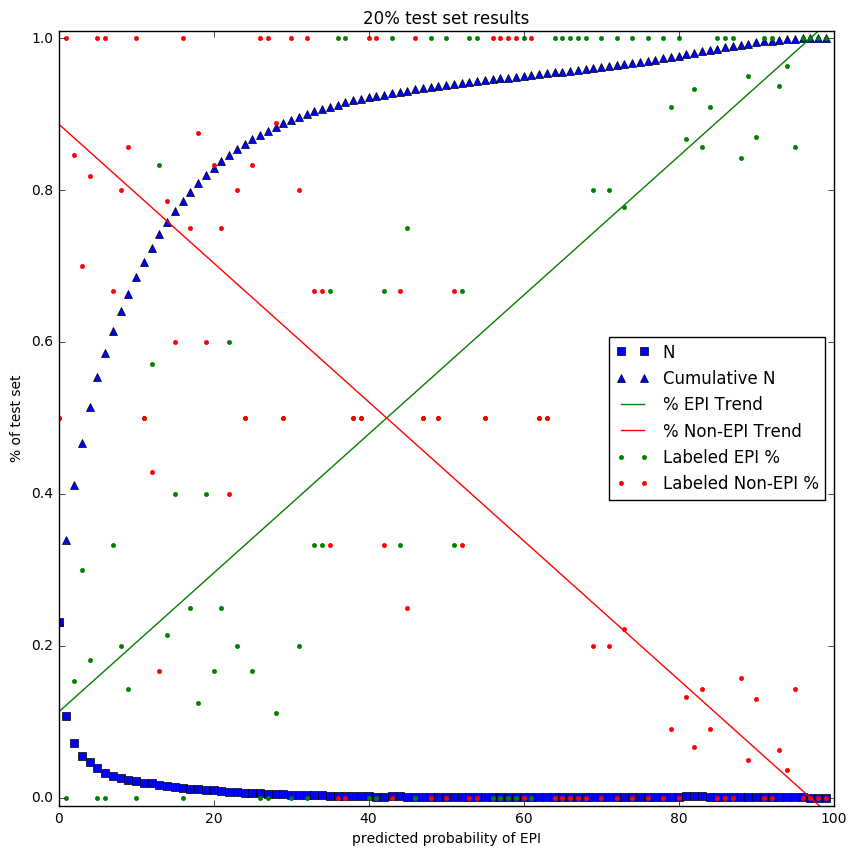

In [208]:
plt.figure(figsize=(10,10))
plt.plot(x_axis, df.pct_of_total, 'bs', label='N')
plt.plot(x_axis, df.cum_pct_of_total, 'b^', label='Cumulative N')
plt.plot(x_axis, df.tp_trendline, 'g-', label='% EPI Trend')
plt.plot(x_axis, df.tn_trendline, 'r-', label='% Non-EPI Trend')
plt.plot(x_axis, df.true_pos_pct, 'g.', label='Labeled EPI %')
plt.plot(x_axis, df.true_neg_pct, 'r.', label='Labeled Non-EPI %')
plt.axis([0, 100, -0.01, 1.01])
plt.ylabel('% of test set')
plt.xlabel('predicted probability of EPI')
plt.title('20% test set results')
plt.legend(loc='right')

# learning curve

In [8]:
from sklearn.model_selection import learning_curve

In [10]:
pnu_test.set_params(**{'base_estimator__n_jobs':-1})

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weigh...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(pnu_test, X_train.values, 
                                                        y_train.values, 
                                                        train_sizes=np.asarray([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                                                        n_jobs=1, verbose=10,
                                                        scoring=FrankenScorer(decision_score='pu_mix_assumed_f1beta10'))

[learning_curve] Training set sizes: [ 11751  23503  47007  70510  94014 117518 141021 164525 188028 211532
 235036]
[CV]  ................................................................
generating 119 samples of indices to use to train multiple estimators, sized 143 elements with last being 59 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.6s


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [ ]:
plt.figure()
plt.title('Learning Curve')
plt.xlabel("Training examples")
plt.ylabel("PU-Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.legend(loc="best")